In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os
import pandas as pd
#%matplotlib notebook
%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
#json_file_name = '/home/dzyga/My/Python/ITJim/Projects/OCR/benchmark_20/gt/3_1.json'
root_folder = '/home/dzyga/My/Python/ITJim/Projects/OCR/plane_images/'
plan_img_file_name = '1_16.png'

In [4]:
plane_img = cv2.imread(root_folder + 'good gt images/' + plan_img_file_name)
imh = plane_img.shape[0]
imw = plane_img.shape[1]

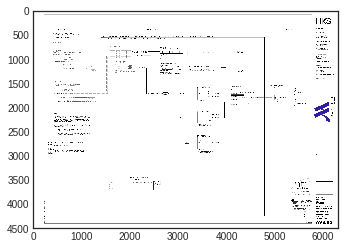

In [5]:
plt.figure()
plt.imshow(plane_img);

In [6]:
json_name = 'predicted_1_16_strings.json'
json_file = '/home/dzyga/My/Python/ITJim/Projects/OCR/plane_images/calamari_result_v1/' + json_name

### working version

In [7]:
# return images from
def crop_with_json(plane_img, json_file, hhh, www):
    """ 20/12/19 by N.
    """
    test_folder = '/home/dzyga/My/Python/ITJim/Projects/OCR/plane_images/result_test/'
    
    with open(json_file, "r") as file:
        text_regions = json.load(file)
        
    images = {}
    for i, box in enumerate(text_regions['TextRegions']):
        string = box['Text']
        x = box['Region']['X']
        y = box['Region']['Y']
        w = box['Region']['W']
        h = box['Region']['H']
        
        xx = int(x*www)
        yy = int(y*hhh)
        ww = int(w*www)
        hh = int(h*hhh)
        
        im_string = plane_img[yy:yy+hh, xx:xx+ww, :].copy()
        
        image_name = str(i) + '.png'
        cv2.imwrite(test_folder + image_name, im_string)
                
        images[str(i)] = [string, im_string, (xx, yy, ww, hh)]
     
    with open(test_folder + 'source.txt',"w+") as f:
        f.write(json_file)
            
    return images

#text_images = crop_with_json(plane_img, json_file)

In [9]:
def split_image_string(im_string):
    """ 19/12/19 by N.
        im_string - image with text to split; must be in gray scale
        imw - plane image width
    """
    _, im_string_g = cv2.threshold(im_string, 150, 255, cv2.THRESH_BINARY)
    text_line = (255-im_string_g).sum(axis = 0)
    text_line = text_line / text_line.max()

    text_line[text_line>0.06] = 1 
    text_line[text_line<0.5] = 0

    xxx = np.arange(len(text_line))
    z_line = np.zeros(len(text_line))

    spaces = xxx[text_line==0]
    
    b = np.zeros(1) # a kind of histogram
    k = 0 # index of histogram
    j = np.zeros(1, dtype=int) # index where white space starts
    for i in range(len(spaces)-1):
        if spaces[i+1] - spaces[i] == 1:
            b[k] += 1 # new item in a bin  
        else:
            j = np.append(j, spaces[i+1])
            b = np.append(b, 1) # move to new bin 
            k += 1 #  

    b12 = (b/2).astype(int)
    ind_all = j+b12 # indeces moved to half up
    #idx = ind_all[b>5]
    ind_largest = np.argsort(b)[::-1]
    idx = ind_all[ind_largest]
    return idx # in px

#index = split_image_string(im_string_g)    

### Working with image v.0

RJ-45 JACK


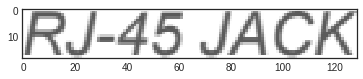

In [17]:
text_images = crop_with_json(plane_img, json_file, imh, imw)
n = 156
string = text_images[str(n)][0]
im_string = text_images[str(n)][1]
im_abs_coord = text_images[str(n)][2]
string_list = string.split(' ')
print(string)
plt.imshow(im_string);

### v.1

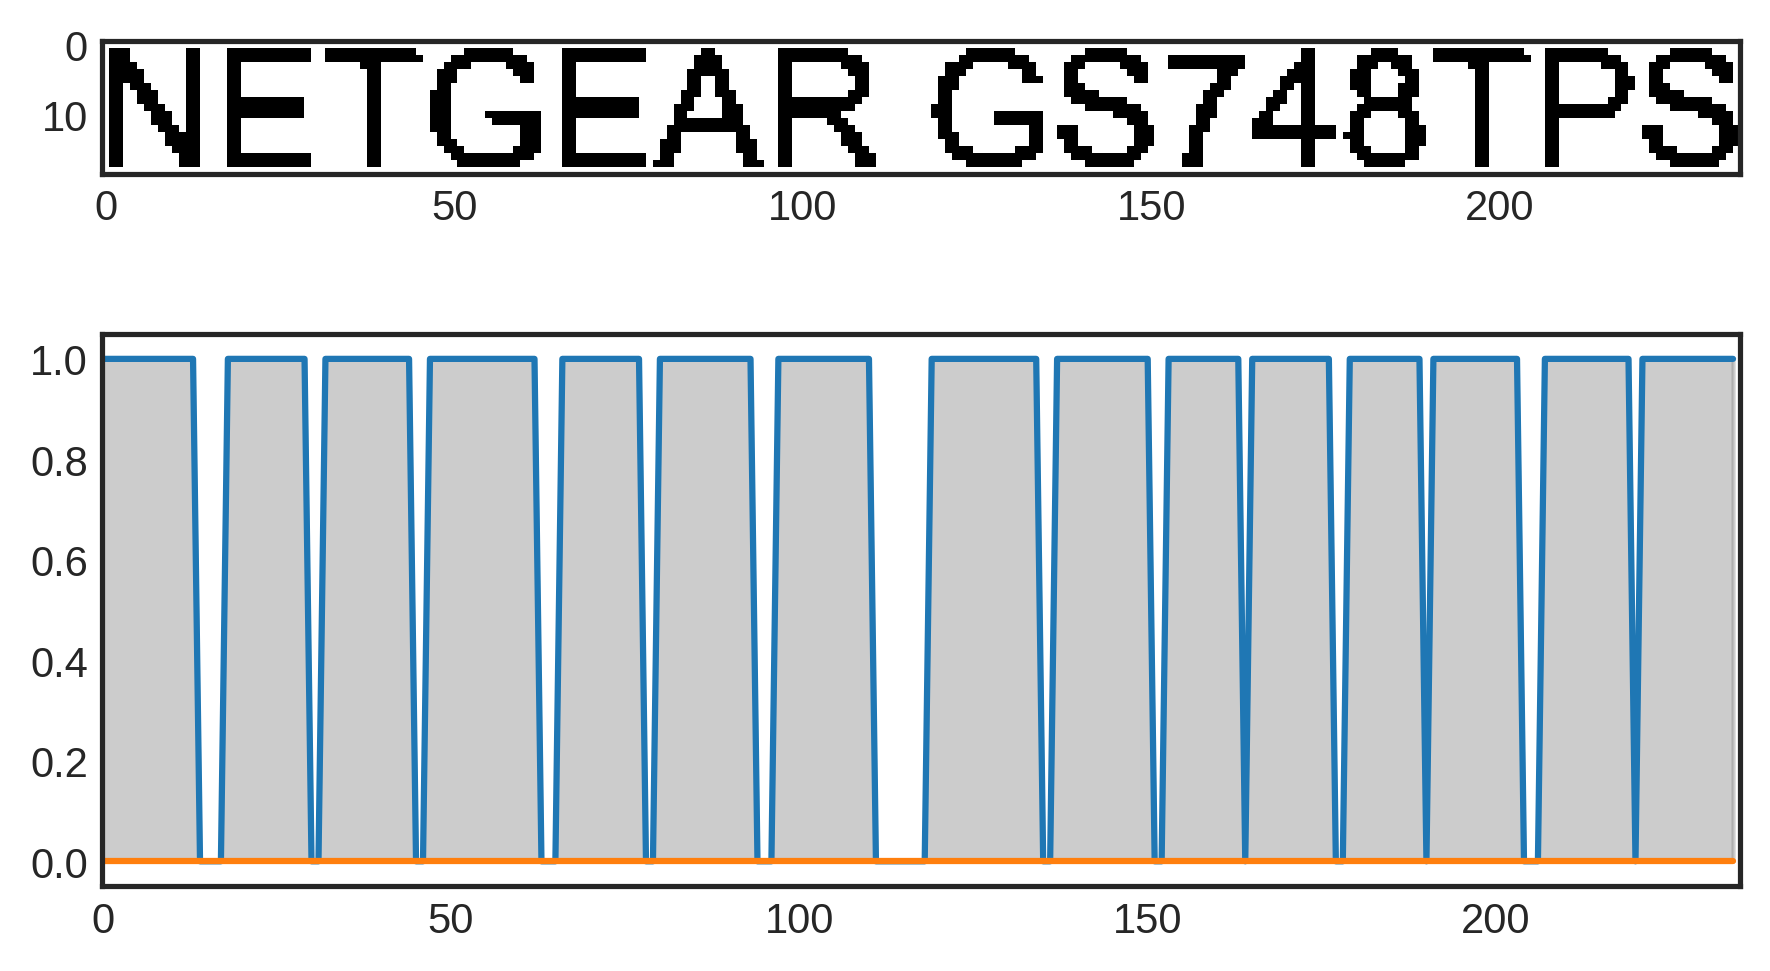

In [106]:
im_string_g = im_string[:,:,0]
_, im_string_g = cv2.threshold(im_string_g, 150, 255,cv2.THRESH_BINARY)
text_line = (255-im_string_g).sum(axis = 0)
text_line = text_line / text_line.max()

text_line[text_line>0.06] = 1 
text_line[text_line<0.5] = 0

text_line[:3] = 1
text_line[-3:] = 1

xxx = np.arange(len(text_line))
z_line = np.zeros(len(text_line))

spaces = xxx[text_line==0] # indeces where text == 0

fig, ax = plt.subplots(2, 1, dpi=300)
ax[0].imshow(im_string_g, cmap = 'gray')
ax[1].plot(xxx, text_line)
ax[1].plot(xxx, z_line)
ax[1].set_xlim(0, im_string.shape[1])
ax[1].fill_between(xxx, z_line, text_line, color='gray', alpha=0.4)

plt.tight_layout()

In [150]:
b = np.zeros(1) # kind of histogram
k = 0 # index of histogram
j = np.zeros(1, dtype=int) # index where white space starts
for i in range(len(spaces)-1):
    if spaces[i+1] - spaces[i] == 1:
        b[k] += 1 # new item in a bin  
    else:
        j = np.append(j, spaces[i+1])
        b = np.append(b, 1) # move to new bin 
        k += 1 #  

b12 = (b/2).astype(int)
ind_all = j+b12 # indeces moved to half up

# takes n higher 
ind_largest = np.argsort(b)[::-1]
idx = ind_all[ind_largest]

print()
N = len(string_list) - 1
idx = idx[:N]

# New coordinates
idx = np.sort(idx)
idx = np.insert(idx, 0, 0) # first idx
idx = np.append(idx, im_string.shape[1]) # last idx

kk = np.arange(len(idx)-1)
#x_word = np.delete(idx, -1) #!!!!!!!!!!!!!!!!!!!!!!
x_word = idx
w_word = idx[kk+1]-idx[kk]


# print('length of the string: ', xxx.shape) 
# print('number of indeces where string is 0: ', spaces.shape)
# print('number of white spaces: ', b.shape)
# print('indeces where all gaps starts: ', j)
# print('indeces of the middle of white spaces: ', idx)

x_word

array([  0, 115, 235])

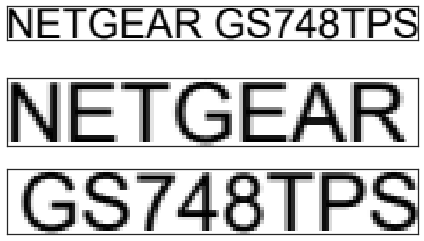

In [151]:
# Cutting! 
im_words = []
for i in range(len(idx)-1):
    im_word = im_string[:, x_word[i]:x_word[i+1], :]
    #cv2.imwrite(words_folder + str(i) + '.png', im_word)
    im_words.append(im_word)

fig, ax = plt.subplots(len(im_words)+1, 1)

for i, axi in enumerate(ax.flat):
    if i == 0:
        axi.imshow(im_string)
        axi.set(xticks=[], yticks=[]);
    else: 
        test_image = im_words[i-1]
        axi.imshow(test_image)
        axi.set(xticks=[], yticks=[]);
plt.tight_layout()


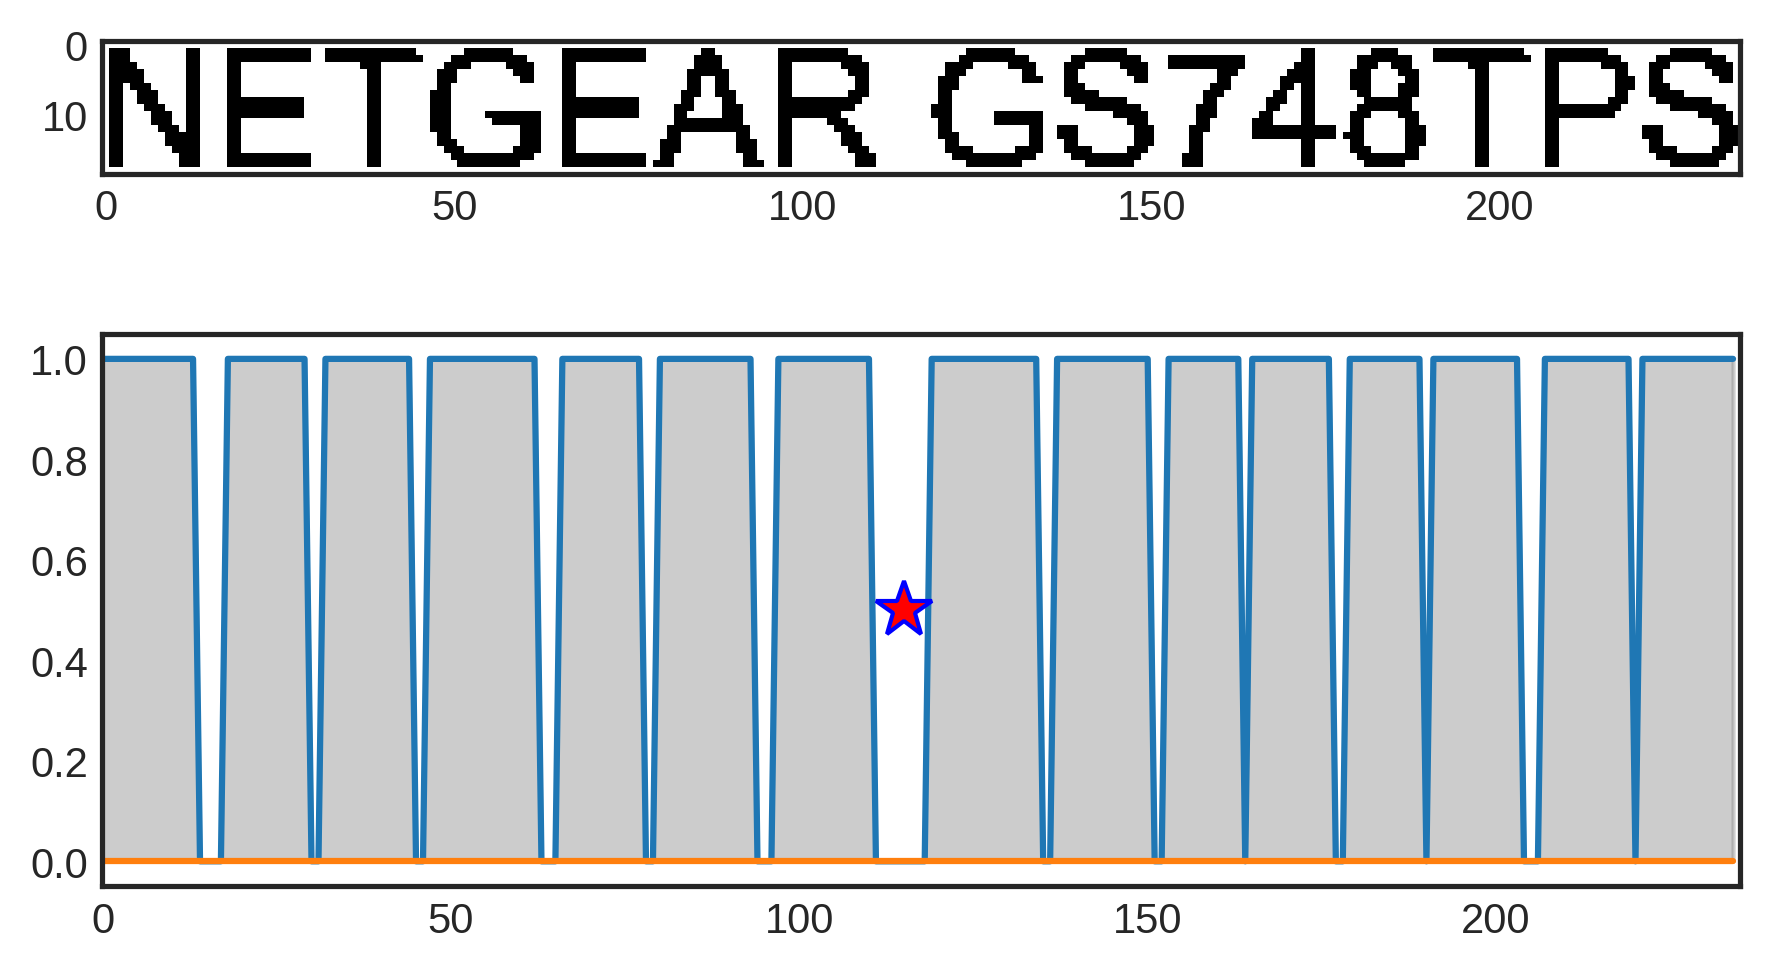

In [139]:
# nice plotting
fig, ax = plt.subplots(2, 1, dpi=300)
ax[0].imshow(im_string_g, cmap = 'gray')
ax[1].plot(xxx, text_line)
ax[1].plot(xxx, z_line)
ax[1].set_xlim(0, im_string.shape[1])
ax[1].fill_between(xxx, z_line, text_line, color='gray', alpha=0.4)
ax[1].plot(idx[1:-1], np.ones(len(idx)-2)*0.5, '*', markersize=14, 
                                            markerfacecolor='red',
                                            markeredgecolor='blue')
plt.tight_layout()

#
#
#  Check crop plane image wiht new json with word coordinates

In [172]:
No = '4_5'
plan_img_file_name = No +'.png'
plane_img = cv2.imread(root_folder + 'good gt images/' + plan_img_file_name)
imhhhh = plane_img.shape[0]
imwwww = plane_img.shape[1]
json_file_w = '/home/dzyga/My/Python/ITJim/Projects/OCR/plane_images/calamari_result/json_words/' + No +'_strings.json'

text_images = crop_with_json(plane_img, json_file_w, imhhhh, imwwww)

In [173]:
len(text_images)

611

SUITE


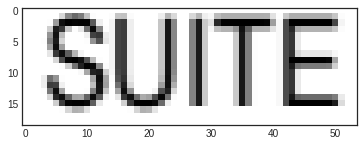

In [176]:
#n = 1000 # WTF ??? no 1_16
n = 167
print(text_images[str(n)][0])
im = text_images[str(n)][1]
plt.imshow(im);